In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
from utils import *

In [2]:
def load_all_data(dir, filecnt=54):
    data = [None]*10
    t = np.zeros((10, filecnt), int)
    for p in range(10):
        d = [None]*filecnt
        for i in range(filecnt):
            d[i] = np.load(f"{dir}/{p}/{i+1}.npy")
            t[p,i] = d[i].shape[0]
        data[p] = d
    return data, t

def load_with_config(dir, config_path, load_nonvalid=False):
    config_arr = np.array(pd.read_csv(f"{config_path}", header=None, skiprows=1))
    data = [[] for i in range(10)]          #create empty 2d list : (10, unknown)
    for config in config_arr:
        #valid check
        if (not config[2]) and (not load_nonvalid):
            continue
        data[int(config[0])] += [np.load(f"{dir}/{int(config[0])}/{int(config[1])+1}.npy")[int(config[3]):int(config[4]),:]]
    
    return data, config_arr

def match_length(d, t:int):
    """
    return
        x : (N, times(t), 2) shape numpy array,
        y : (N)
    """
    N = sum([len(d[i]) for i in range(len(d))])
    x = np.zeros((N, t, 2), np.float64)
    y = np.zeros((N), np.float64)
    target_timepoints = np.linspace(0, 1, t)
    start_at = 0
    for r in range(len(d)):
        for c in range(len(d[r])):
            origin_timepoints = np.linspace(0, 1, d[r][c].shape[0])
            x[start_at + c, :, 0] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,0])
            x[start_at + c, :, 1] = np.interp(target_timepoints, origin_timepoints, d[r][c][:,1])
        y[start_at:start_at + len(d[r])] = r
        start_at += len(d[r])
    return x, y 

def apply_normalize(d):
    for r in range(len(d)):
        for c in range(len(d[r])):
            channels = d[r][c].shape[1]
            min_vals = np.min(d[r][c][:, :], axis=0)
            max_vals = np.max(d[r][c][:, :], axis=0)
            min_max_diff = np.array([max_vals[j] - min_vals[j] for j in range(channels)])
            factor = min_max_diff / np.max(min_max_diff)
            for ch in range(channels):
                d[r][c][:, ch] = ((d[r][c][:, ch] - min_vals[ch])/min_max_diff[ch])*factor[ch]
    
def plot_data(d):
    plt.figure(figsize=(20,4))
    plt.subplot(2,1,1)
    gca = plt.gca()
    gca.plot(d[:,0])
    plt.subplot(2,1,2)
    gca = plt.gca()
    gca.plot(d[:,1])
    plt.tight_layout()
    plt.show()

def plot_data2(d, save=None, cmap_name="gist_rainbow", xlim1=None, ylim1=None, xlim2=None, ylim2=None, xlim3=None, ylim3=None):
    fig, axes = plt.subplot_mosaic("abbbb;acccc", figsize=(20,4))
    draw_gradation(d[:,0], d[:,1], axes["a"],cmap_name=cmap_name, xlim=xlim1, ylim=ylim1)
    draw_gradation(np.arange(d.shape[0]), d[:,0], axes["b"],cmap_name=cmap_name, xlim=xlim2, ylim=ylim2)
    draw_gradation(np.arange(d.shape[0]), d[:,1], axes["c"],cmap_name=cmap_name, xlim=xlim3, ylim=ylim3)

    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

def plot_data3(origin, syn, save, cmap_name="gist_rainbow"):
    fig, axes = plt.subplot_mosaic("abbbb;acccc;deeee;dffff", figsize=(20,8))
    draw_gradation(origin[:,0], origin[:,1], axes["a"],cmap_name=cmap_name, xlim=[0,1], ylim=[0,1])
    draw_gradation(np.arange(origin.shape[0]), origin[:,0], axes["b"],cmap_name=cmap_name, ylim=[0,1])
    draw_gradation(np.arange(origin.shape[0]), origin[:,1], axes["c"],cmap_name=cmap_name, ylim=[0,1])
    draw_gradation(syn[:,0], syn[:,1], axes["d"], cmap_name=cmap_name, xlim=[0,1], ylim=[0,1])
    draw_gradation(np.arange(syn.shape[0]), syn[:,0], axes["e"],cmap_name=cmap_name, ylim=[0,1])
    draw_gradation(np.arange(syn.shape[0]), syn[:,1], axes["f"],cmap_name=cmap_name, ylim=[0,1])
    axes["a"].set_title("Original")
    axes["d"].set_title("Synthetic")

    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

legacy : config 없이 불러오기

In [3]:
# data, t = load_all_data("/home/user/workspace/research/eye-writing/self_data/")
# apply_normalize(data)

In [4]:
# target_data = data
# save_dir = "/home/user/img"
# for r in range(len(target_data)):
#     for c in range(len(target_data[r])):
#         plot_data2(target_data[r][c], f"{save_dir}/Pattern_{r}_Index_{c}.png", "gist_rainbow")

config이랑 불러오기

In [5]:
data, config = load_with_config("/home/user/workspace/research/eye-writing/self_data/", "/home/user/workspace/research/eye-writing/load_data_config.csv", load_nonvalid=False)
apply_normalize(data)
# plot_data2(data[9][53], xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

In [6]:
target_data = data
save_dir = "/home/user/img"
for r in range(len(target_data)):
    target_pattern_config = config[config[:,0] == r, :]
    indexes = target_pattern_config[target_pattern_config[:,2]==1, 1]
    print(f"pattern {r}, length = {len(target_data[r])}, indexes len = {indexes.shape}")
    for c in range(len(target_data[r])):
        plot_data2(target_data[r][c], save=f"{save_dir}/Pattern_{r}_Index_{indexes[c]}.png", cmap_name="gist_rainbow", xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

pattern 0, length = 51, indexes len = (51,)
pattern 1, length = 49, indexes len = (49,)
pattern 2, length = 50, indexes len = (50,)
pattern 3, length = 52, indexes len = (52,)
pattern 4, length = 50, indexes len = (50,)
pattern 5, length = 53, indexes len = (53,)
pattern 6, length = 51, indexes len = (51,)
pattern 7, length = 50, indexes len = (50,)
pattern 8, length = 50, indexes len = (50,)
pattern 9, length = 49, indexes len = (49,)


정규화 처리

In [7]:
x, y = match_length(data, 200)
print(x.shape)
print(y.shape)
pattern = 0
x = x[y==pattern]
print(x.shape)


(505, 200, 2)
(505,)
(51, 200, 2)


In [8]:
# target_data = x
# save_dir = "/home/user/img"
# for i in range(len(target_data)):
#     plot_data2(target_data[i], f"{save_dir}/{i}.png", "gist_rainbow",  xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

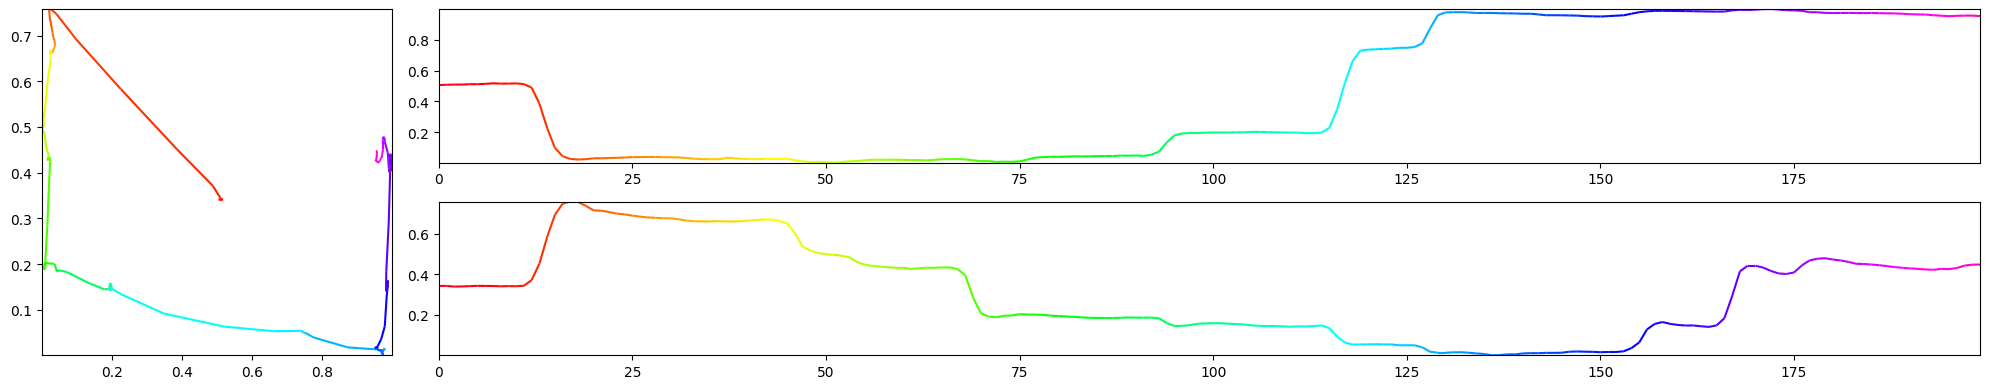

In [9]:
plot_data2(x[0], None)

TIMEGAN

In [10]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [11]:
#Specific to TimeGANs
seq_len=x.shape[1]
n_seq = x.shape[2]
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 16

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [12]:
modelname = f"pattern_{pattern}.pkl"
if path.exists(modelname):
    synth = TimeGAN.load(modelname)
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(x, train_steps=1000)
    synth.save(modelname)

2023-02-04 13:34:14.316781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-04 13:34:14.324823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-04 13:34:14.325075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-04 13:34:14.328931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [13]:
synth_data = synth.sample(len(x))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 4/4 [00:00<00:00,  6.93it/s]

(64, 200, 2)


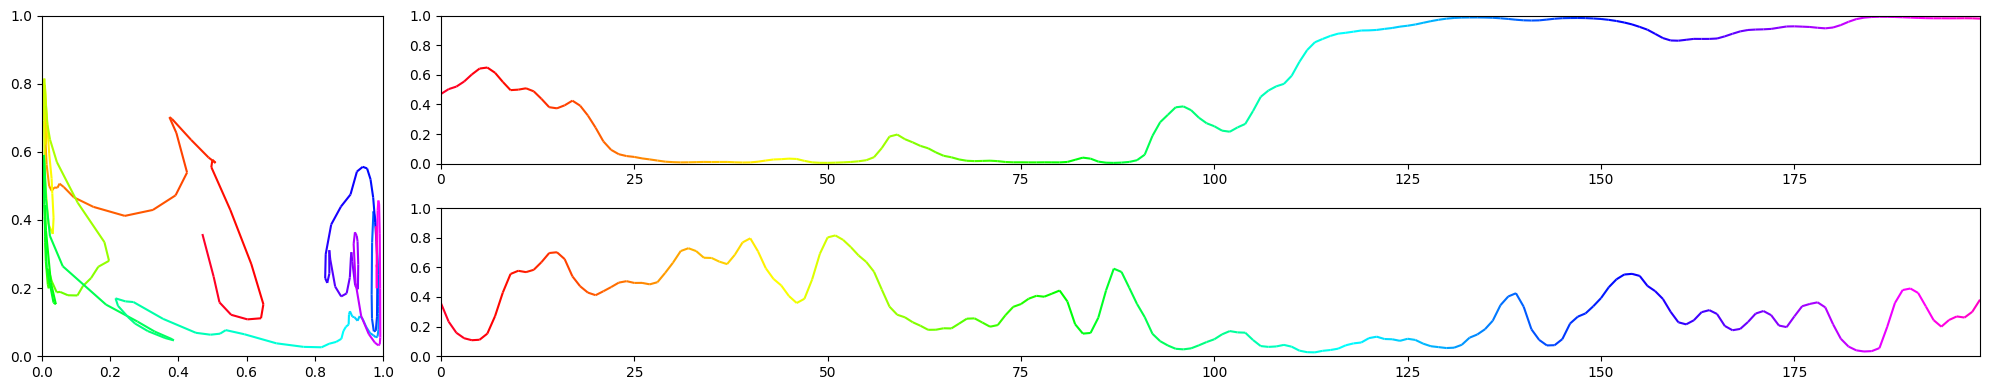

In [14]:
plot_data2(synth_data[0], None, xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

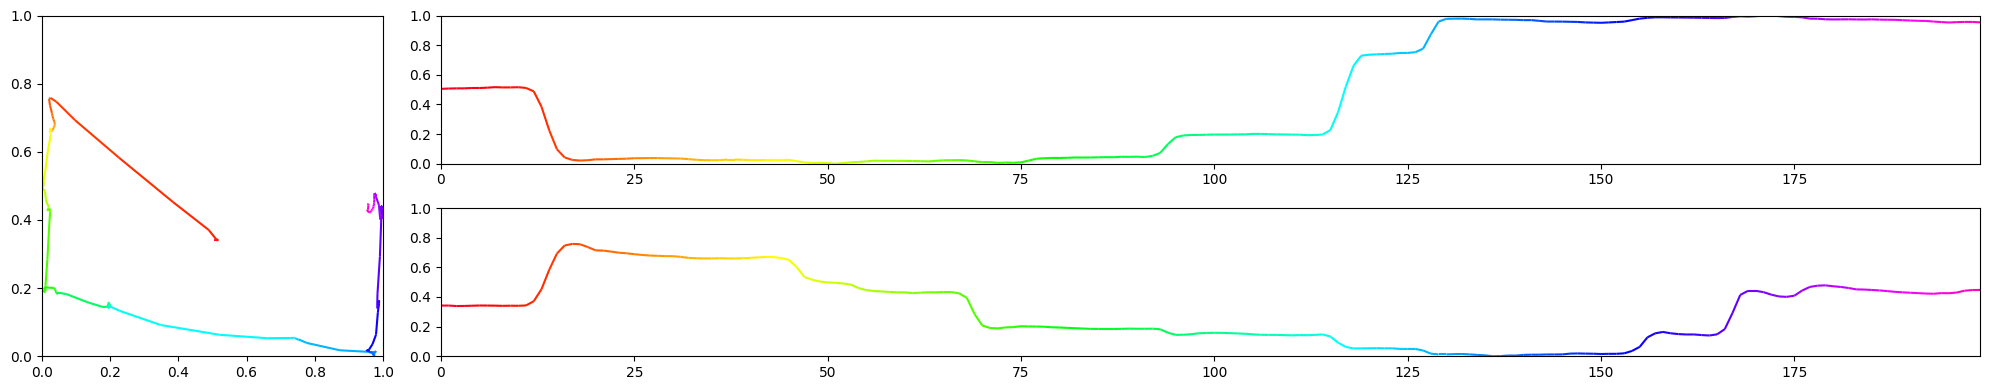

In [15]:
plot_data2(x[0], None, xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

In [16]:
# target_data = synth_data
# save_dir = f"/home/user/syn{pattern}"
# for i in range(len(synth_data)):
#     plot_data2(synth_data[i], f"{save_dir}/{i}.png", "gist_rainbow",   xlim1=[0, 1], ylim1=[0,1], ylim2=[0,1], ylim3=[0,1])

In [17]:
# save_dir = f"/home/user/compare_images_{pattern}"
# for i in range(len(x)):
#     plot_data3(x[i], synth_data[i], f"{save_dir}/{i}.png", "winter_r")

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(x))[:sample_size]

real_sample = np.asarray(x)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

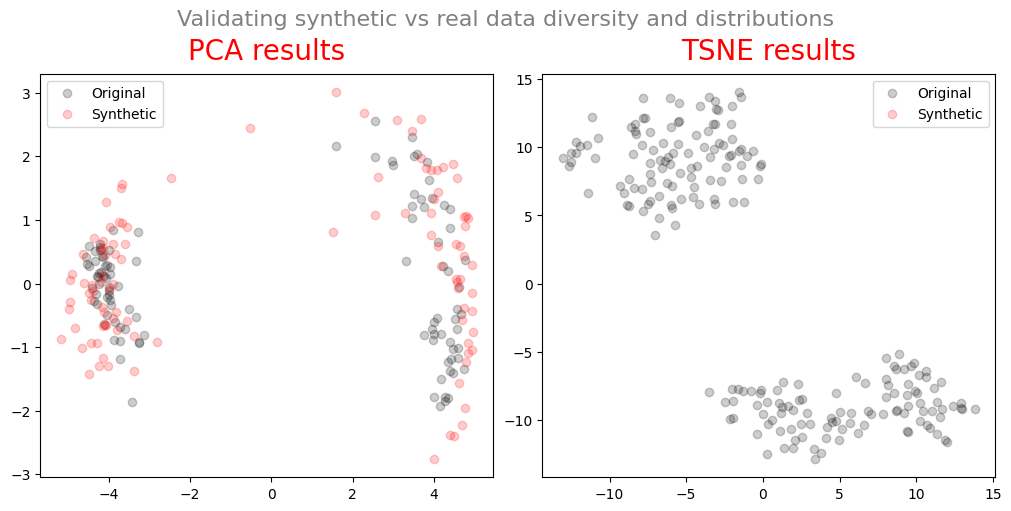

In [19]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(10,5))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')